In [32]:
from becquerel import Spectrum
import numpy as np
import matplotlib.pyplot as plt
import becquerel as bq
import scipy.integrate as integrate
import math as m
import importlib
import os
import sys
sys.path.append("../")
import PF
import ROI
import analysis_methods as am

In [33]:
importlib.reload(PF)
importlib.reload(ROI)
importlib.reload(am)

<module 'analysis_methods' from '..\\analysis_methods.py'>

In [34]:
def f_near(a,a0):
    idx = np.abs(a-a0).argmin()
    return idx

def plot_peak_region(roi, spectrum, sourcen_energies, key):
    roi.find_peak_energies()
    target_peaks = roi.target_peaks
    spec = spectrum
    counts = spec.counts_vals
    energies = spec.bin_centers_kev
    idx = f_near(energies,key) 
    roi_low = idx - 50
    roi_high = idx + 50

    plot_counts = counts[roi_low:roi_high]
    plot_energies = energies[roi_low:roi_high]
        
    roi_low_bins,roi_peak_bins,roi_high_bins = roi.get_roi_windows(roi.roi_pars["%s" %key])
    rlow = roi_low_bins[0][0]
    rhi = roi_high_bins[0][-1]
    plot_counts = counts[rlow:rhi]
    plot_energies = energies[rlow:rhi]

    rlow = roi_low_bins[0][0]
    rhi = roi_low_bins[0][-1]
    low_counts = counts[rlow:rhi]
    low_energies = energies[rlow:rhi]

    rlow = roi_high_bins[0][0]
    rhi = roi_high_bins[0][-1]
    high_counts = counts[rlow:rhi]
    high_energies = energies[rlow:rhi]

    rlow = roi_peak_bins[0][0]
    rhi = roi_peak_bins[0][-1]
    peak_counts = counts[rlow:rhi]
    peak_energies = energies[rlow:rhi]

    fig,ax = plt.subplots()
    ax.plot(plot_energies,plot_counts)
    ax.fill_between(low_energies,0,low_counts,facecolor = 'green',interpolate=True)
    ax.fill_between(high_energies,0,high_counts,facecolor = 'red',interpolate=True)
    ax.fill_between(peak_energies,0,peak_counts,facecolor = 'blue',interpolate=True)
    ax.set_yscale('log')
    plt.title("%s Peak" %key)

In [35]:
def plot_spec(spectrum, xmode='channel'):
    if xmode == 'channel':
        facecolor = 'green'
    else:
        facecolor = 'blue'
    plt.figure()
    spectrum.fill_between(xmode=xmode, facecolor=facecolor, alpha=0.4, ax=plt.gca())
    spectrum.plot('k-', lw=0.7, xmode=xmode, ax=plt.gca())
    if xmode == 'channel':
        plt.xlim(0, spectrum.bin_edges_raw.max())
        plt.title('Uncalibrated spectrum')
    else:
        plt.xlim(0, spectrum.energies_kev[-1])
        plt.title('Calibrated spectrum')
    plt.yscale('log')
    plt.ylim(2e-1)
    plt.tight_layout()
def plot_calibrator(cal):
    cal.peakfinder.spectrum.apply_calibration(cal.cal)
    print('fit gain:', cal.gain, 'keV/channel')
    print('fit channels:', cal.fit_channels)

    plt.figure()
    plt.title('Peaks used in fit')
    cal.plot()
    plt.tight_layout()
    #plt.savefig('peaks used in fit.png',dpi = 200)

    plot_spec(cal.peakfinder.spectrum, xmode='channel')
    for x, erg in zip(cal.fit_channels, cal.fit_energies):
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-10:chan+10].max() * 1.5
        plt.plot([x, x], [1e-1, y], 'r-', alpha=0.5)
        plt.text(x, y, '{:.1f} keV'.format(erg))
    #plt.savefig('Uncal spec.png',dpi = 200)


    plot_spec(cal.peakfinder.spectrum, xmode='energy')
    for erg in cal.fit_energies:
        x = int(erg / cal.gain)
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-15:chan+15].max() * 1.5
        plt.plot([erg, erg], [1e-1, y], 'r-', alpha=0.5)
        plt.text(erg, y, '{:.1f} keV'.format(erg))
    #plt.savefig('cal spec.png',dpi=200)

In [36]:
path = r'C:\Users\Daniel\Desktop\Radwatch\radwatch-analysis'
spec = path + r'\NAA_eff_calibration_long.Spe'
bg = path + r'\background-long.Spe'
#ecal = path + r'\E-calibration-Eu152.Spe'
#this set of eff data was already energy calibrated

spec = bq.Spectrum.from_file(spec)
bg = bq.Spectrum.from_file(bg)
#ecal = bq.Spectrum.from_file(ecal)

counts = spec.counts_vals
energies = spec.bin_centers_kev

SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\radwatch-analysis\NAA_eff_calibration_long.Spe
SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\radwatch-analysis\background-long.Spe


In [37]:
#Find Lu-176, La-138, K-40
source_isotopes = np.array(['Lu_176_1','Lu_176_2','Lu_176_3',
                          'La_138_1','La_138_2',
                           'K-40']); #get counts under the peak subtrack the background
source_energies = np.array([88.34,201.83,306.78,
                           788.742,1435.795,
                           1460.83]);
source_activities = np.array([16.259,16.259,16.259,
                             11.646,11.646,
                              424.65]);#Bq/L, update this with correct mass, by .0098 g
branching_ratio = np.array([0.11,0.86,0.94,
                           0.34,0.66,
                           0.11]);
activities_uncer = np.array([1.6259,1.6259,1.6259,
                            0.02329,0.02329,
                            0.8493])
'''The real source energies:
Lu-176: 88.34, 201.83, 306.78
La-138: 788.742,1435.795
K-40: 1460.83'''
source_activities = source_activities * .0098 #accounting for NAA sample weight
activities_uncer = activities_uncer * .0098
print(source_activities)
print(type(source_energies[0]))
type(88.34)

[0.1593382 0.1593382 0.1593382 0.1141308 0.1141308 4.16157  ]
<class 'numpy.float64'>


float

In [38]:
roi = ROI.ROI(spec, bg, source_energies, 0)#0 for different calibrations
roi.find_peak_energies()
roi_counts, roi_unc = roi.get_counts()
print(roi_counts)
print(roi_unc)

background spec sidebands 25295.874428152074
bg peak counts 25966.594933422944
signal bg 22251.0
signal peak 23768.0
background spec sidebands 16582.40729573939
bg peak counts 17193.6796371466
signal bg 15096.5
signal peak 20248.999999999996
background spec sidebands 10999.271723109145
bg peak counts 9581.5918459331
signal bg 9839.5
signal peak 13025.0
background spec sidebands 3510.164484621225
bg peak counts 3651.2971484502095
signal bg 2973.0
signal peak 3423.0
background spec sidebands 1147.6672245128736
bg peak counts 1172.6263772800576
signal bg 1296.5
signal peak 1144.0
background spec sidebands 4087.8554204871352
bg peak counts 1206.2077828213596
signal bg 4125.5
signal peak 1757.0
[846.2794947291295, 4541.227658592787, 4603.179877176044, 308.86733617101527, -177.45915276718392, 513.1476376657756]
[271.1236473410222, 230.82922970242805, 181.73050846648636, 101.5671176649255, 59.487057327930536, 84.08261112183021]


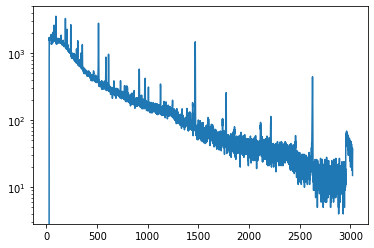

In [39]:
plt.plot(energies,counts)
plt.yscale('log')

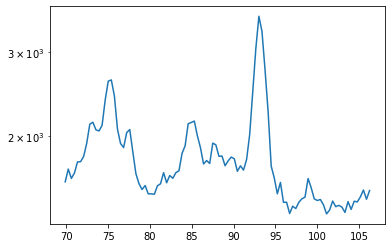

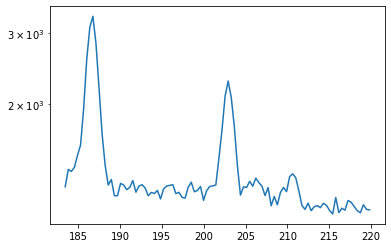

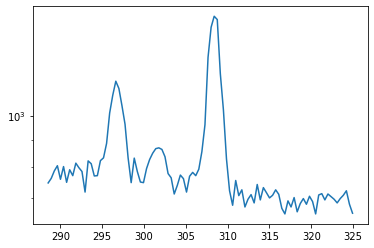

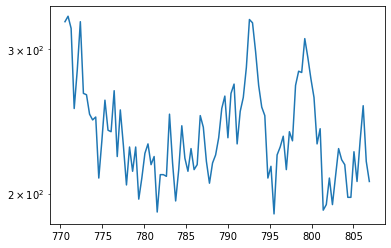

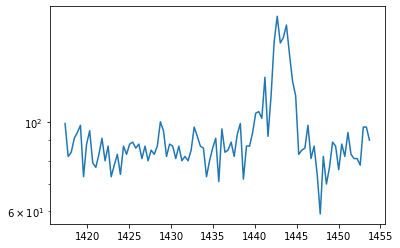

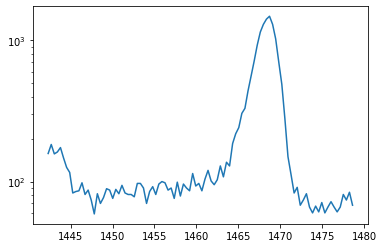

In [40]:
for i in source_energies:
    index0 = f_near(energies, i)
    plt.plot(energies[index0-50:index0+50], counts[index0-50:index0+50])
    plt.yscale('log')
    plt.show()

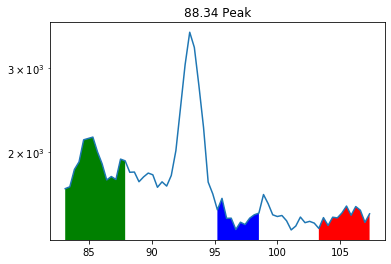

In [41]:
roi.set_sideband(float(source_energies[0]), 5, [[-2, -0.925], [.4, 1.2], [2, 3]])
#roi.set_sideband(1460, 5, [[-2, -1], [-0.5, 0.725], [1, 2]])
#roi.set_sideband(2614, 5, [[-2, -1], [-0.575, 0.675], [1, 2]])

plot_peak_region(roi, spec, source_energies, float(source_energies[0]))
#plot_peak_region(roi, spec, source_energies, 1460)
#plot_peak_region(roi, spec, source_energies, 2614)